# Evaluation of predictions

## Linking Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!pip install datasets
from datasets import load_dataset
cuad = load_dataset("cuad")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 44.5 MB/s 
     |████████████████████████████████| 182 kB 54.7 MB/s 
     |████████████████████████████████| 115 kB 57.1 MB/s 
     |████████████████████████████████| 127 kB 47.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Generating train split:   0%|          | 0/22450 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4182 [00:00<?, ? examples/s]

Dataset cuad downloaded and prepared to /root/.cache/huggingface/datasets/cuad/default/1.0.0/01ed7dc61ab84230462731422e77cbb6f54ea8590b22a2d881b594f4d7f3746c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Evaluation

### Calculating AUPR

In [108]:
!python /content/drive/MyDrive/CSI5386-Assignment_2/evalutation/github-code/evaluate.py

Results for RoBERTa - Base : 
[1, 0.8811881188118812, 0.8811881188118812, 0.8811881188118812, 0.8811881188118812, 0.865546218487395, 0.8646616541353384, 0.8636363636363636, 0.8518518518518519, 0.8333333333333334, 0.8299595141700404, 0.8293650793650794, 0.583756345177665, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
AUPR: 0.108, Precision at 80% Recall: 0.000, Precision at 90% Recall: 0.000
Results for BERT-base : 
[1, 0.9090909090909091, 0.9090909090909091, 0.8833333333333333, 0.8833333333333333, 0.8382352941176471, 0.8235294117647058, 0.6967213114754098, 0.6888888888888889, 0.66875, 0.6666666666666666, 0.6009615384615384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Calculating F1 and EM scores

In [102]:
# these functions are heavily influenced by the HF squad_metrics.py script
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        #print("TEXT : "+text)
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

def get_gold_answers(example):
    """helper function that retrieves all possible true answers from a cuad example"""
    
    if (len(example["text"])==0):
      gold_answers = [""]
    else:
      gold_answers = example["text"]

    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    
        
    return gold_answers

In [20]:
import json
import numpy as np
def get_f1_em_scores(file):
  predicted_values = []
  confidence_scores = []

  # Opening JSON file
  f = open(file)

  # returns JSON object as a dictionary
  data = json.load(f)


  for i in range(len(data)):
      
      predicted_value  = data[i].get(list(data[i].keys())[0])
      confidence_score = data[i].get(list(data[i].keys())[1])

      if (confidence_score<0.000001):
          predicted_value=""
      
      # print(str(predicted_value)+" with confidence of "+str(confidence_score))
      predicted_values.append(predicted_value)
      confidence_scores.append(confidence_score)
    
  # Closing file
  f.close()

  f1_scores = []
  em_scores = []

  for index in range(len(predicted_values)):
      gold_answers = get_gold_answers(cuad["test"]["answers"][index])
      f1_score = max((compute_f1(predicted_values[index], answer)) for answer in gold_answers)
      em_score = max((compute_exact_match(predicted_values[index], answer)) for answer in gold_answers)
      f1_scores.append(f1_score)
      em_scores.append(em_score)

  print("Average F1 : "+str(np.mean(f1_scores)))
  print("Average EM : "+str(np.mean(em_scores)))

In [21]:
print("Results for RoBERTa - Base : ")
get_f1_em_scores("/content/drive/MyDrive/CSI5386-Assignment_2/trained-models/roberta-base-CUAD/predictions-roberta-base-cuad-checkpoint-8000.json")
   
print("Results for BERT-base : ")
get_f1_em_scores("/content/drive/MyDrive/CSI5386-Assignment_2/trained-models/bert-CUAD/predictions-bert-cuad-checkpoint-4000.json")

print("Results for Legal-BERT : ")
get_f1_em_scores("/content/drive/MyDrive/CSI5386-Assignment_2/trained-models/legal-bert-CUAD/predictions-legal-bert-cuad-checkpoint-7000.json")


Results for RoBERTa - Base : 
Average F1 : 0.6414132145535926
Average EM : 0.6320346320346321
Results for BERT-base : 
Average F1 : 0.7367830797976926
Average EM : 0.7111228255139694
Results for Legal-BERT : 
Average F1 : 0.756983003024498
Average EM : 0.7477399913904433


### Results by categories

In [103]:
def get_category_score(category,file):
 
  # storing all the f1 scores for the specific category
  f1_scores_for_category = []

  # Opening JSON file
  f = open(file)

  # returns JSON object as a dictionary
  data = json.load(f)

  
  for i in range(len(data)):
      
      # Getting the name of the category predicted
      pred_category = list(data[i].keys())[0]

      # Getting the predicted value
      predicted_value  = data[i].get(list(data[i].keys())[0])

      # Getting the confidence score
      confidence_score = data[i].get(list(data[i].keys())[1])

      # if (confidence_score<0.000001):
      #     predicted_value=""
      category_corr = "__"+category
      if (category_corr in pred_category):
        # print(category + " = "+ pred_category)
        gold_answers = get_gold_answers(cuad["test"]["answers"][i])

        f1_score = max((compute_f1(predicted_value, answer)) for answer in gold_answers)
        #em_score = max((compute_exact_match(predicted_value, answer)) for answer in gold_answers)
        f1_scores_for_category.append(f1_score)
  
  return np.mean(f1_scores_for_category)


In [104]:
# import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_category_performance(file):
  categories = ['Document Name','Parties','Agreement Date','Effective Date','Expiration Date','Renewal Term','Notice Period To Terminate Renewal','Governing Law','Most Favored Nation','Non-Compete','Exclusivity','No-Solicit Of Customers','Competitive Restriction Exception','No-Solicit Of Employees','Non-Disparagement','Termination For Convenience','Rofr/Rofo/Rofn','Change Of Control','Anti-Assignment','Revenue/Profit Sharing','Price Restrictions','Minimum Commitment','Volume Restriction','Ip Ownership Assignment','Joint Ip Ownership','License Grant','Non-Transferable License','Affiliate License-Licensor','Affiliate License-Licensee','Unlimited/All-You-Can-Eat-License','Irrevocable Or Perpetual License','Source Code Escrow','Post-Termination Services','Audit Rights','Uncapped Liability','Cap On Liability','Liquidated Damages','Warranty Duration','Insurance','Covenant Not To Sue','Third Party Beneficiary']
  f1_score_category = []
  for elem in categories:
    f1_score_category.append(get_category_score(elem,file))

  # Create a pandas dataframe
  df = pd.DataFrame({"Categories": categories,
                    "Scores": f1_score_category})
 
  df = df.sort_values('Scores',ascending=False)
  sns.set(rc={'figure.figsize':(5,10)})
  # make barplot and sort bars
  sns.barplot(y='Categories',x="Scores", data=df,color="Blue").set(title='CUAD Performance by Category')
  plt.savefig(file+'.png')


Results for Legal-BERT : 


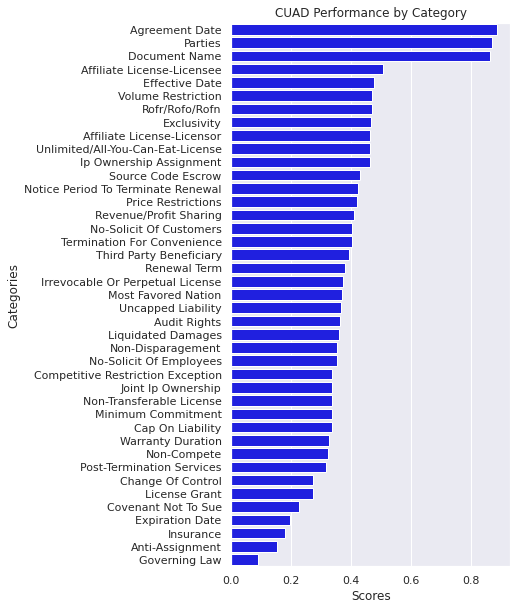

In [107]:
# print("Results for RoBERTa - Base : ")
# get_category_performance("/content/drive/MyDrive/CSI5386-Assignment_2/trained-models/roberta-base-CUAD/predictions-roberta-base-cuad-checkpoint-8000.json")

# print("Results for BERT-base : ")
# get_category_performance("/content/drive/MyDrive/CSI5386-Assignment_2/trained-models/bert-CUAD/predictions-bert-cuad-checkpoint-4000.json")
# plt.savefig('bert-categories.png')
print("Results for Legal-BERT : ")
get_category_performance("/content/drive/MyDrive/CSI5386-Assignment_2/trained-models/legal-bert-CUAD/predictions-legal-bert-cuad-checkpoint-7000.json")
# plt.savefig('legal-bert-categories.png')

### Precision-recall curve

<Figure size 360x720 with 0 Axes>

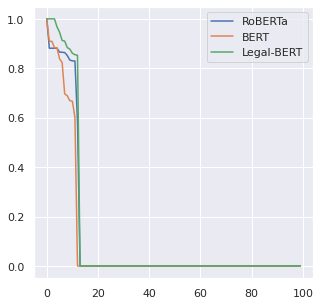

In [116]:
data = [
    [1, 0.8811881188118812, 0.8811881188118812, 0.8811881188118812, 0.8811881188118812, 0.865546218487395, 0.8646616541353384, 0.8636363636363636, 0.8518518518518519, 0.8333333333333334, 0.8299595141700404, 0.8293650793650794, 0.583756345177665, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0.9090909090909091, 0.9090909090909091, 0.8833333333333333, 0.8833333333333333, 0.8382352941176471, 0.8235294117647058, 0.6967213114754098, 0.6888888888888889, 0.66875, 0.6666666666666666, 0.6009615384615384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1.0, 1.0, 1.0, 1.0, 0.9672131147540983, 0.9459459459459459, 0.912621359223301, 0.9099099099099099, 0.8837209302325582, 0.8776978417266187, 0.8607594936708861, 0.8548387096774194, 0.8526315789473684, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]


# importing package
import matplotlib.pyplot as plt
import numpy as np
  

  
# plot lines
plt.clf()
plt.figure(figsize=(5, 5))
plt.plot(range(0,100), data[0], label = "RoBERTa")
plt.plot(range(0,100), data[1], label = "BERT")
plt.plot(range(0,100), data[2], label = "Legal-BERT")
plt.legend()
plt.show()

